In [32]:
import sys 

import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from scipy.integrate import solve_ivp # to ODE system
from scipy.optimize import differential_evolution # to minimization problem from least-squares fitting
from scipy.stats import entropy

### Data extraction and transformation

In [33]:
url_df_brazil = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'

df_brazil = pd.read_csv(url_df_brazil)

df_brazil.dtypes

epi_week                                   int64
date                                      object
country                                   object
state                                     object
city                                      object
newDeaths                                  int64
deaths                                     int64
newCases                                   int64
totalCases                                 int64
deathsMS                                   int64
totalCasesMS                               int64
deaths_per_100k_inhabitants              float64
totalCases_per_100k_inhabitants          float64
deaths_by_totalCases                     float64
recovered                                float64
suspects                                 float64
tests                                    float64
tests_per_100k_inhabitants               float64
vaccinated                               float64
vaccinated_per_100_inhabitants           float64
vaccinated_second   

In [34]:
df_brazil.date = pd.to_datetime(df_brazil.date)

In [35]:
def convert_df_to_state_cases_by_day(df):
    
    first_day = df_brazil.date.min()
    last_day = df_brazil.date.max() - pd.DateOffset(1)
    day_columns = pd.date_range(first_day, last_day, freq='D').strftime('%Y-%m-%d')
    
    df_temp = pd.DataFrame()
    df_temp['States'] = df_brazil.state.sort_values().unique()

    for day_i in day_columns:
        column = []
        for state_i in df_brazil.state.sort_values().unique():
            
            if df.query('state == @state_i & date == @day_i').values.any():
                # newCases = column 7
                column.append(df.query('state == @state_i & date == @day_i').values[0][7])
            else:
                column.append(0)

        df_temp[day_i] = column
        
    return df_temp

In [36]:
df_brazilian_states_cases = convert_df_to_state_cases_by_day(df_brazil)

In [37]:
df_brazil_final = df_brazilian_states_cases.T
df_brazil_final.columns = df_brazil_final.iloc[0]
df_brazil_final = df_brazil_final.drop([df_brazil_final.index[0]])
df_brazil_final.index = pd.to_datetime(df_brazil_final.index)

### Brazilian events

In [22]:
holiday = ['2020-02-26',
           '2020-04-10',
           '2020-04-21',
           '2020-05-01',
           '2020-06-11',
           '2020-10-12',
           '2020-11-02',
           '2020-11-15',
           '2020-12-25',
           '2021-01-01',
           '2021-02-16',
           '2021-04-02',
           '2021-04-21',
           '2021-05-01']

canceled_holiday = ['2020-09-07']

elections = ['2020-11-15',
             '2020-11-29']

political_interventions = ['2020-04-16', #Mandetta left
                           '2020-05-15', #Teich left 
                           '2021-03-23'] #Pazuello left

restriction_flexibility = ['2020-08-01'] #Flexibilization in São Paulo
        
lockdown_ini = ['2020-05-05']#,'2020-11-01']
lockdown_end = ['2020-06-14']#,'2021-01-30']

In [23]:
moving_average = 14 #dias

In [11]:
df_brazil_rolled = df_brazil_final['TOTAL'].rolling(moving_average, min_periods=1).mean()

---------------------

# Epidemiological SEIRD Model

In [13]:
def seird_model(t, y, alpha=1/4, beta=0.5, epsilon=0.001, gamma=1/14, mu=0.001):
    
    S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
    
    S_prime = - S * ( beta * I + epsilon * E )
    E_prime = S * ( beta * I + epsilon * E ) - E * ( alpha )
    I_prime = alpha * E - I * ( gamma  + mu )
    R_prime = gamma * I 
    D_prime = mu * I
    
    return S_prime, E_prime, I_prime, R_prime, D_prime

In [14]:
# This function numerically integrates a system of ordinary differential equations given an initial value

def seird_ode_solver(y0, t_span, t_eval, alpha=1/4, beta=0.5, epsilon=0.001, gamma=1/14, mu=0.001):
    
    # scipy.integrate.solve_ivp(fun, t_span, y0, t_eval=None, args=None)
    solution_ODE = solve_ivp(
        fun=lambda t, y: seird_model(t, 
                                     y,
                                     alpha=alpha,
                                     beta=beta,
                                     epsilon=epsilon,
                                     gamma=gamma,
                                     mu=mu), 
        y0=y0,
        t_span=t_span,
        t_eval=t_eval
    )
    
    return solution_ODE

In [15]:
def seird_least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + \
           weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

In [16]:
# Finds the global minimum of a multivariate function.

def solve_differential_evolution(y0, data_time, data_temporal):
    # alpha ~1/4days | gamma ~ 1/14days
    bounds_seird = [(1/6, 1/2), (0.001, 1), (0.001, 1), (1/18, 1/10), (0.001, 1)]
    
    I_temporal, D_temporal = data_temporal

    result_seird = differential_evolution(
        seird_least_squares_error_ode, 
        bounds=bounds_seird,
        args=(data_time, 
              [I_temporal, D_temporal], 
              seird_ode_solver, 
              y0), 
        updating='deferred',
        popsize=30,
        strategy='best1bin',
        tol=1e-2,
        polish=True,
        recombination=0.7,
        seed=1,
        workers=-1
    )

    return result_seird

In [17]:
def get_solution_ode_values(result_seird):
    alpha_fitted, beta_fitted, epsilon_fitted, gamma_fitted, mu_fitted = result_seird.x # SEIRD parameters
    
    model_list = list()
    beta_list = list()
    alpha_list = list()
    gamma_list = list()
    epsilon_list = list()
    mu_list = list()
    R0_list = list()
    Rt_list = list()

    model_list.append("SEIRD")
    beta_list.append(beta_fitted)
    alpha_list.append(alpha_fitted)
    gamma_list.append(gamma_fitted)
    epsilon_list.append(epsilon_fitted)
    mu_list.append(mu_fitted)
    R0_list.append((epsilon_fitted/alpha_fitted) + (beta_fitted/(gamma_fitted+mu_fitted)))
    Rt_list.append(beta_fitted/(gamma_fitted+mu_fitted))
   
    parameters_dict = {
        "Model": model_list,
        "alpha": alpha_list,
        "beta": beta_list,
        "epsilon": epsilon_list,
        "gamma": gamma_list,
        "mu": mu_list,
        "R0": R0_list,
        "Rt": Rt_list
    }

    df_parameters_calibrated = pd.DataFrame(parameters_dict)

    return df_parameters_calibrated

------------

### Training SEIRD model

In [19]:
df_seird = df_brazil[df_brazil['state']=='TOTAL'].fillna(0)
df_seird['day'] = df_seird.date.apply(lambda x: (x - df_seird.date.min()).days)

# population
N = int( 100000 / df_seird.totalCases_per_100k_inhabitants.min() )

In [20]:
parameters_fitted_list = list()
dia = 0
for first_day in range(0, df_seird.day.max() - moving_average):
    
    if df_seird[df_seird['day'] == first_day].day.any():

        # collecting data from specific period (0 to 14 days | 1 to 15 days | 2 to 16 days)
        df_temp = df_seird[first_day:first_day + moving_average]
        
        # inital contidion of the compartments
        E0 = df_temp.newCases.values[0] 
        I0 = df_temp.newCases.values[0] 
        R0 = df_temp.recovered.values[0] + df_temp.vaccinated.values[0]
        D0 = df_temp.deaths.values[0]
        S0 = N - E0 - I0 - R0 - D0
        
        Y0 = (S0/N , E0/N , I0/N , R0/N , D0/N)

        # collecting temporal data        
        I_temporal = ((I0 + 
                       df_temp.newCases - df_temp.newCases.min()) 
                      / N) 
        
        R_temporal = ((R0 + 
                       (df_temp.recovered - df_temp.recovered.min()) + 
                       (df_temp.vaccinated - df_temp.vaccinated.min()))
                      / N)
        
        D_temporal = ((D0 + 
                      df_temp.deaths - df_temp.deaths.min()) 
                      / N)
        
        data_time = df_temp.day.values.astype(np.float64)

        # estimating parameters
        result_seird = solve_differential_evolution(Y0, data_time, (I_temporal, D_temporal))

        # exporting parameter values
        parameters_fitted = get_solution_ode_values(result_seird)
        
        parameters_fitted_list.append(
            (df_seird[df_seird['day']==first_day].date.dt.strftime('%Y-%m-%d'), 
             parameters_fitted)
        )

In [22]:
def gen_df_parameters_fitted(parameters_fitted_list, holiday_list):

    date_list = list()
    alpha_list = list()
    beta_list = list()
    epsilon_list = list()
    gamma_list = list()
    mu_list = list()
    R0_list = list()
    Rt_list = list()

    is_holiday = False
    holiday_period = 0
    holiday_period_list = list()

    for parameters_i in parameters_fitted_list:

        date_list.append(parameters_i[0].values[0])

        if (parameters_i[0].values[0] in holiday_list) and not is_holiday:
            holiday_period_list.append(1)
            is_holiday = True

        elif is_holiday:
            holiday_period += 1
            if holiday_period < 14:
                holiday_period_list.append(1)
            else:
                holiday_period = 0
                is_holiday = False
                holiday_period_list.append(0)

        else:
            holiday_period_list.append(0)

        alpha_list.append(parameters_i[1].alpha.values[0])
        beta_list.append(parameters_i[1].beta.values[0])
        epsilon_list.append(parameters_i[1].epsilon.values[0])
        gamma_list.append(parameters_i[1].gamma.values[0])
        mu_list.append(parameters_i[1].mu.values[0])
        R0_list.append(parameters_i[1].R0.values[0])
        Rt_list.append(parameters_i[1].Rt.values[0])
    
    parameters = {"Date": date_list,
                  "holiday": holiday_period_list,
                  "R0": R0_list, 
                  "Rt": Rt_list,
                  "alpha": alpha_list,
                  "beta": beta_list,
                  "epsilon": epsilon_list,
                  "gamma": gamma_list,
                  "mu": mu_list}

    return pd.DataFrame(parameters)

In [23]:
df_parameters_seird = gen_df_parameters_fitted(parameters_fitted_list, holiday)

In [24]:
df_parameters_seird

,Date,holiday,R0,Rt,alpha,beta,epsilon,gamma,mu
0,2020-02-26,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711
1,2020-02-27,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711
2,2020-02-28,1,3.107842,0.011379,0.166911,0.001227,0.516834,0.098784,0.009050
3,2020-02-29,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711
4,2020-03-01,1,1.059129,0.460340,0.331031,0.326627,0.198218,0.085822,0.623711
...,...,...,...,...,...,...,...,...,...
460,2021-05-31,0,1.478004,1.343340,0.498510,0.116903,0.067131,0.056585,0.030439
461,2021-06-01,0,1.150430,1.130765,0.327838,0.128236,0.006447,0.095781,0.017625
462,2021-06-02,0,1.078544,0.301101,0.168275,0.024196,0.130824,0.065151,0.015207
463,2021-06-03,0,1.405396,0.471748,0.215555,0.053296,0.201252,0.095299,0.017677


In [6]:
df_parameters_seird['R0_ma'] = df_parameters_seird['R0'].rolling(moving_average, min_periods=1).mean()
df_parameters_seird['Rt_ma'] = df_parameters_seird['Rt'].rolling(moving_average, min_periods=1).mean()

df_parameters_seird['cases'] = df_seird[1:df_seird.day.max() - moving_average].newCases.values
df_parameters_seird['deaths'] = df_seird[1:df_seird.day.max() - moving_average].newDeaths.values
df_parameters_seird = df_parameters_seird.drop(columns='Unnamed: 0')

In [5]:
df_parameters_seird.Date = pd.to_datetime(df_parameters_seird.Date)
df_parameters_seird.set_index('Date', inplace=True)

In [8]:
corr = (
    df_parameters_seird[
        ['cases', 'deaths', 'R0_ma', 'Rt_ma', 'holiday']
    ]
    .corr(method='pearson')
)
corr.style.background_gradient(cmap='coolwarm')

,cases,deaths,R0_ma,Rt_ma,holiday
cases,1.000000,0.858211,-0.478908,-0.098614,-0.143449
deaths,0.858211,1.000000,-0.325866,0.000398,-0.027512
R0_ma,-0.478908,-0.325866,1.000000,0.654455,0.181284
Rt_ma,-0.098614,0.000398,0.654455,1.000000,0.025692
holiday,-0.143449,-0.027512,0.181284,0.025692,1.000000


In [9]:
df_parameters_seird.Date = pd.to_datetime(df_parameters_seird.Date)

### Plot: Transmission rate and COVID-19 daily cases

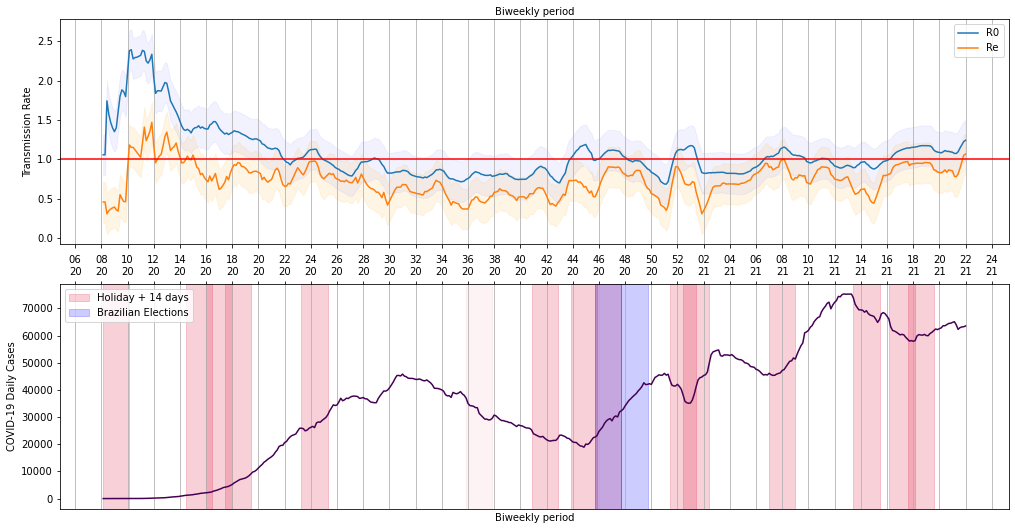

In [71]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(17, 10))
fig.autofmt_xdate()

#--------------- ax1

#some confidence interval
ci = 0.95 * np.std(df_parameters_seird['R0_ma'])/np.mean(df_parameters_seird['R0_ma'])
ci = 0.95 * np.std(df_parameters_seird['Rt_ma'])/np.mean(df_parameters_seird['Rt_ma'])

ax1.plot(df_parameters_seird['Date'], df_parameters_seird['R0_ma'], label="R0")
ax1.plot(df_parameters_seird['Date'], df_parameters_seird['Rt_ma'], label="Re")

ax1.fill_between(df_parameters_seird['Date'], 
                 (df_parameters_seird['R0_ma']-ci), 
                 (df_parameters_seird['R0_ma']+ci), 
                 color='b', 
                 alpha=.05)

ax1.fill_between(df_parameters_seird['Date'],
                 (df_parameters_seird['Rt_ma']-ci), 
                 (df_parameters_seird['Rt_ma']+ci), 
                 color='orange', 
                 alpha=.1)

ax1.grid(axis='x')
ax1.axhline(y=1, color='r', linestyle='-')

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.set_ylabel("Transmission Rate")
ax1.set_xlabel("Biweekly period")
ax1.xaxis.set_label_position('top')

ax1.legend()

#--------------- ax2

ax2.plot(df_parameters_seird['Date'], 
         df_parameters_seird['cases'].rolling(moving_average, min_periods=1).mean(), 
         color=plt.cm.viridis(0))

# ax2.plot(df_parameters_seird['Date'], 
#          df_parameters_seird['deaths'].rolling(moving_average, min_periods=1).mean(), 
#          color=plt.cm.viridis(1),
#          label='COVID-19 Daily Deaths')

ax2.grid(axis='x')

ax2.set_xlabel("Biweekly period")
ax2.set_ylabel("COVID-19 Daily Cases")

ax2.set_xticklabels([])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('bottom')

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))

for i in range(len(holiday)):
    ax2.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.2)
    
for i in range(len(elections)):
    ax2.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.2)
    
for i in range(len(canceled_holiday)):
    ax2.axvspan(datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.05)
    
# for i in range(len(political_interventions)):
#     ax2.axvspan(datetime.datetime.strptime(political_interventions[i], '%Y-%m-%d'), 
#                datetime.datetime.strptime(political_interventions[i], '%Y-%m-%d') + datetime.timedelta(days=2), 
#                label="Political Intervention",
#                color="green", 
#                alpha=0.2)
    
# for i in range(len(restriction_flexibility)):
#     ax2.axvspan(datetime.datetime.strptime(restriction_flexibility[i], '%Y-%m-%d'), 
#                datetime.datetime.strptime('2020-11-01', '%Y-%m-%d'), 
#                label="Flexibility Restrictions",
#                color="black", 
#                alpha=0.05)

def remove_duplicate_labels_from_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
remove_duplicate_labels_from_legends(ax2)

plt.subplots_adjust(hspace=0.175)

plt.savefig('./images/brazil_r0_rt_cases.pdf', transparent=True)  
plt.show()

In [9]:
isH_isR = df_parameters_seird[(df_parameters_seird['holiday']==1) & (df_parameters_seird['R0_ma']>1)]['R0_ma'].count()
isH_notR = df_parameters_seird[(df_parameters_seird['holiday']==1) & ~(df_parameters_seird['R0_ma']>1)]['R0_ma'].count()
notH_isR = df_parameters_seird[~(df_parameters_seird['holiday']==1) & (df_parameters_seird['R0_ma']>1)]['R0_ma'].count()
notH_notR = df_parameters_seird[~(df_parameters_seird['holiday']==1) & ~(df_parameters_seird['R0_ma']>1)]['R0_ma'].count()

total = isH_isR + isH_notR + notH_isR + notH_notR

print(f'Days that are Holiday with R0 > 1 : {isH_isR} - {isH_isR*100/total:.2f}%')
print(f'Days that are Holiday with R0 <= 1 : {isH_notR} - {isH_notR*100/total:.2f}%')
print(f'Days that are not Holiday with R0 > 1 : {notH_isR} - {notH_isR*100/total:.2f}%')
print(f'Days that are not Holiday with R0 <= 1 : {notH_notR} - {notH_notR*100/total:.2f}%')

Days that are Holiday with R0 > 1 : 133 - 28.79%
Days that are Holiday with R0 <= 1 : 40 - 8.66%
Days that are not Holiday with R0 > 1 : 92 - 19.91%
Days that are not Holiday with R0 <= 1 : 197 - 42.64%


In [10]:
entropy_holiday_r0 = (
    df_parameters_seird
    .groupby('holiday')['R0_ma']
    .apply(lambda x : entropy(x.value_counts(), base=2))
    .reset_index()
)

entropy_holiday_r0

,holiday,R0_ma
0,0,8.174926
1,1,7.423068


In [11]:
entropy_holiday_cases = (
    df_parameters_seird
    .groupby('holiday')['cases']
    .apply(lambda x : entropy(x.value_counts(), base=2))
    .reset_index()
)

entropy_holiday_cases

,holiday,cases
0,0,8.154164
1,1,7.309475


In [7]:
path = './dbs/handled/'
df_brazil_final.to_csv(path + 'df_brazilian_states_cases.csv')
df_brazil_rolled.to_csv(path + 'df_brazil_rolled_cases.csv')
df_seird.to_csv(path + 'df_brazil_appllied_seird_model.csv')
df_parameters_seird.to_csv(path + 'df_parameters_seird.csv')

In [19]:
path = './dbs/handled/'
df_parameters_seird = pd.read_csv(path + 'df_parameters_seird.csv')
df_parameters_seird.Date = pd.to_datetime(df_parameters_seird.Date)

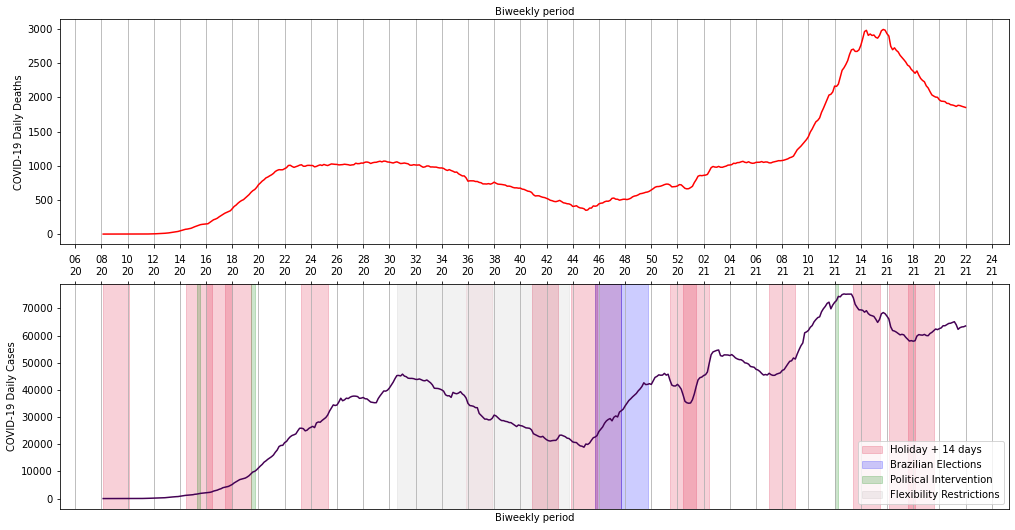

In [61]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(17, 10))
fig.autofmt_xdate()

#--------------- ax1

ax1.plot(df_parameters_seird['Date'], 
         df_parameters_seird['deaths'].rolling(moving_average, min_periods=1).mean(), 
         color='r')


ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.set_ylabel("COVID-19 Daily Deaths")
ax1.set_xlabel("Biweekly period")
ax1.grid(axis='x')
ax1.xaxis.set_label_position('top')

#--------------- ax2

ax2.plot(df_parameters_seird['Date'], 
         df_parameters_seird['cases'].rolling(moving_average, min_periods=1).mean(), 
         color=plt.cm.viridis(0))

ax2.grid(axis='x')

ax2.set_xlabel("Biweekly period")
ax2.set_ylabel("COVID-19 Daily Cases")

ax2.set_xticklabels([])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('bottom')

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))

for i in range(len(holiday)):
    ax2.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.2)
    
for i in range(len(elections)):
    ax2.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.2)
    
for i in range(len(canceled_holiday)):
    ax2.axvspan(datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.05)
    
for i in range(len(political_interventions)):
    ax2.axvspan(datetime.datetime.strptime(political_interventions[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(political_interventions[i], '%Y-%m-%d') + datetime.timedelta(days=2), 
               label="Political Intervention",
               color="green", 
               alpha=0.2)
    
for i in range(len(restriction_flexibility)):
    ax2.axvspan(datetime.datetime.strptime(restriction_flexibility[i], '%Y-%m-%d'), 
               datetime.datetime.strptime('2020-11-01', '%Y-%m-%d'), 
               label="Flexibility Restrictions",
               color="black", 
               alpha=0.05)

def remove_duplicate_labels_from_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
remove_duplicate_labels_from_legends(ax2)

plt.subplots_adjust(hspace=0.175)

plt.savefig('./images/brazil_cases_deaths_curves.pdf', transparent=True)  
plt.show()

In [56]:
df_brazil_final[:450]

States,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,RJ,RN,RO,RR,RS,SC,SE,SP,TO,TOTAL
2020-02-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2020-02-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-02-28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2020-02-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-15,161,734,507,161,4043,6703,883,1197,201,458,...,5216,935,450,232,4241,2391,717,15486,250,67351
2021-05-16,61,691,210,190,2554,2826,894,711,147,131,...,828,2814,218,84,641,1167,955,7554,313,37564
2021-05-17,162,676,312,202,1917,2302,1049,1711,3079,359,...,1932,667,484,170,450,1461,1100,4001,534,35598
2021-05-18,29,545,663,207,3890,3358,592,1875,2957,979,...,5509,1173,805,446,5714,3703,1004,15779,585,74805


In [29]:
grafico_brazil_cases_sp

0          1
1          0
2          0
3          1
4          0
       ...  
472    22875
473    21221
474     9272
475     5309
476    23227
Name: SP, Length: 477, dtype: int64

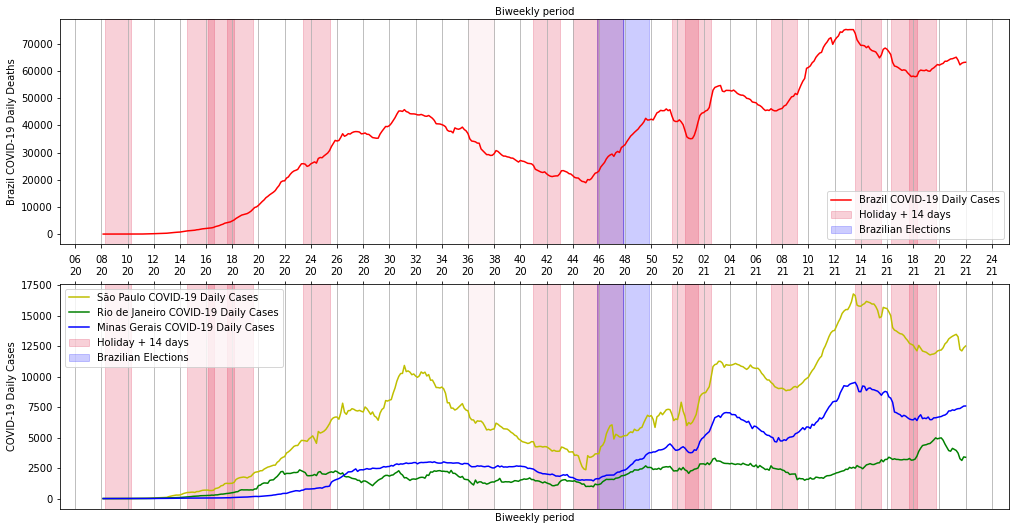

In [69]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(17, 10))
fig.autofmt_xdate()

#--------------- ax1

ax1.plot(df_brazil_final['TOTAL'][:462].rolling(moving_average, min_periods=1).mean(),
         color='r',
        label='Brazil COVID-19 Daily Cases')



ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.set_ylabel("Brazil COVID-19 Daily Deaths")
ax1.set_xlabel("Biweekly period")
ax1.grid(axis='x')
ax1.xaxis.set_label_position('top')

for i in range(len(holiday)):
    ax1.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.2)
    
for i in range(len(elections)):
    ax1.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.2)
    
for i in range(len(canceled_holiday)):
    ax1.axvspan(datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.05)
    
ax1.legend()
remove_duplicate_labels_from_legends(ax1)

#--------------- ax2

ax2.plot(df_brazil_final['SP'][:462].rolling(moving_average, min_periods=1).mean(), 
         color='y', label='São Paulo COVID-19 Daily Cases')

ax2.plot(df_brazil_final['RJ'][:462].rolling(moving_average, min_periods=1).mean(), 
         color='g', label='Rio de Janeiro COVID-19 Daily Cases')

ax2.plot(df_brazil_final['MG'][:462].rolling(moving_average, min_periods=1).mean(), 
         color='b', label='Minas Gerais COVID-19 Daily Cases')

ax2.grid(axis='x')

ax2.set_xlabel("Biweekly period")
ax2.set_ylabel("COVID-19 Daily Cases")
for i in range(len(holiday)):
    ax2.axvspan(datetime.datetime.strptime(holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.2)
    
for i in range(len(elections)):
    ax2.axvspan(datetime.datetime.strptime(elections[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(elections[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Brazilian Elections",
               color="blue", 
               alpha=0.2)
    
for i in range(len(canceled_holiday)):
    ax2.axvspan(datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d'), 
               datetime.datetime.strptime(canceled_holiday[i], '%Y-%m-%d') + datetime.timedelta(days=14), 
               label="Holiday + 14 days",
               color="crimson", 
               alpha=0.05)


ax2.set_xticklabels([])
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('bottom')
ax2.legend()

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W\n%y'))

def remove_duplicate_labels_from_legends(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
remove_duplicate_labels_from_legends(ax2)

plt.subplots_adjust(hspace=0.175)

plt.savefig('./images/brazil_and_states_cases.pdf', transparent=True)  
plt.show()